In [1]:
import sys

print(sys.version)
print(sys.path)
print("---")
print(sys.executable)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:18) 
[GCC 10.3.0]
['/home/studio-lab-user/TFM', '/home/studio-lab-user/.conda/envs/forecast/lib/python38.zip', '/home/studio-lab-user/.conda/envs/forecast/lib/python3.8', '/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/lib-dynload', '', '/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages']
---
/home/studio-lab-user/.conda/envs/forecast/bin/python


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.utils.plotting import plot_correlations

from aux_functions import *

### Read data

In [3]:
# Cargamos los datos de los Buildings y Solars
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("data/phase_2_data.tsf")

print(loaded_data)
print(frequency)
print(forecast_horizon)
print(contain_missing_values)
print(contain_equal_length)

   series_name     start_timestamp  \
0    Building0 2016-07-03 21:30:00   
1    Building1 2019-01-09 23:15:00   
2    Building3 2016-03-01 04:15:00   
3    Building4 2019-07-03 04:45:00   
4    Building5 2019-07-25 23:00:00   
5    Building6 2019-07-25 01:45:00   
6       Solar0 2020-04-25 14:00:00   
7       Solar1 2018-12-31 13:00:00   
8       Solar2 2019-06-05 14:00:00   
9       Solar3 2019-06-05 14:00:00   
10      Solar4 2019-06-05 14:00:00   
11      Solar5 2019-01-15 13:00:00   

                                         series_value  
0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
8

In [4]:
#Principio y fin de cada edificio, los unimos en una unica lista
total_df = []
var_names = loaded_data['series_name'].values

for var in var_names:
    print('--', var)

    # Obtenemos la fecha de inicio y la cantidad de datos de cada building y panel
    start_time = loaded_data[loaded_data['series_name'] == var]['start_timestamp'].values[0]
    value_data = loaded_data[loaded_data['series_name'] == var]['series_value'].values[0]

    df = pd.DataFrame(data = np.array(value_data).astype(np.float64),
                      index = pd.date_range(start = start_time, periods = len(value_data), 
                      freq = '15min'), columns = [var])

    print(df.shape)
    print(f"Start: {df.index[0]} ,  End: {df.index[-1]}")

    total_df.append(df)

-- Building0
(151786, 1)
Start: 2016-07-03 21:30:00 ,  End: 2020-10-31 23:45:00
-- Building1
(63459, 1)
Start: 2019-01-09 23:15:00 ,  End: 2020-10-31 23:45:00
-- Building3
(163759, 1)
Start: 2016-03-01 04:15:00 ,  End: 2020-10-31 23:45:00
-- Building4
(46733, 1)
Start: 2019-07-03 04:45:00 ,  End: 2020-10-31 23:45:00
-- Building5
(44548, 1)
Start: 2019-07-25 23:00:00 ,  End: 2020-10-31 23:45:00
-- Building6
(44633, 1)
Start: 2019-07-25 01:45:00 ,  End: 2020-10-31 23:45:00
-- Solar0
(18184, 1)
Start: 2020-04-25 14:00:00 ,  End: 2020-10-31 23:45:00
-- Solar1
(64364, 1)
Start: 2018-12-31 13:00:00 ,  End: 2020-10-31 23:45:00
-- Solar2
(49384, 1)
Start: 2019-06-05 14:00:00 ,  End: 2020-10-31 23:45:00
-- Solar3
(49384, 1)
Start: 2019-06-05 14:00:00 ,  End: 2020-10-31 23:45:00
-- Solar4
(49384, 1)
Start: 2019-06-05 14:00:00 ,  End: 2020-10-31 23:45:00
-- Solar5
(62924, 1)
Start: 2019-01-15 13:00:00 ,  End: 2020-10-31 23:45:00


In [5]:
#to DataFrame
aggr_df = pd.concat(total_df, axis=1) #outer join on date

#Anañadimos el mes noviembre al agregado
nov_dates = pd.date_range(start = '2020-11-01', end = '2020-11-30 23:45:00', freq='15min')
aggr_df = aggr_df.reindex(aggr_df.index.append(nov_dates))

#Cargamos los datos climatologicos
weather_df = pd.read_csv('data/ERA5_Weather_Data_Monash.csv', index_col = 0, parse_dates = True)

#Ponemos los datos en la misma frecuencia
weather_df = weather_df.resample('15min').interpolate('linear')

#Unimos todo en un mismo DataFrame
phase2_df = aggr_df.join(weather_df, how='outer')

In [6]:
#Renombramos las variables quitando caracteres especiales
phase2_df.rename(columns={'coordinates (lat,lon)':'coordinates', 'model (name)':'model',
                          'model elevation (surface)':'model_elevation',
                          'utc_offset (hrs)':'utc_offset',
                          'temperature (degC)':'temperature', 
                          'dewpoint_temperature (degC)':'dewpoint_temperature',
                          'wind_speed (m/s)':'wind_speed', 
                          'mean_sea_level_pressure (Pa)':'mean_sea_level_pressure',
                          'relative_humidity ((0-1))':'relative_humidity_01',
                          'surface_solar_radiation (W/m^2)':'surface_solar_radiation',
                          'surface_thermal_radiation (W/m^2)':'surface_thermal_radiation',
                          'total_cloud_cover (0-1)':'total_cloud_cover'}, inplace=True)

#Delimitamos los datos para que empiezen desde el primer registro de los eficios
phase2_df = phase2_df['2019-07-03 04:45:00':'2020-11-30 23:45:00']
phase2_df.head()

,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,...,model_elevation,utc_offset,temperature,dewpoint_temperature,wind_speed,mean_sea_level_pressure,relative_humidity_01,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover
2019-07-03 04:45:00,NaN,22.6,856.0,2.0,NaN,NaN,NaN,0.0,0.0,0.0,...,69.59,10.0,12.410,9.8700,1.955,103139.840,0.8475,222.7875,331.305,0.8625
2019-07-03 05:00:00,NaN,30.3,856.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,69.59,10.0,12.440,9.9000,1.990,103147.250,0.8500,228.8800,331.450,0.8600
2019-07-03 05:15:00,NaN,7.1,817.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,...,69.59,10.0,12.195,9.8025,1.935,103153.085,0.8575,199.5000,332.170,0.8350
2019-07-03 05:30:00,NaN,15.3,817.0,2.0,NaN,NaN,NaN,0.0,0.0,0.0,...,69.59,10.0,11.950,9.7050,1.880,103158.920,0.8650,170.1200,332.890,0.8100
2019-07-03 05:45:00,NaN,22.3,817.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,69.59,10.0,11.705,9.6075,1.825,103164.755,0.8725,140.7400,333.610,0.7850


In [7]:
df_zeros = []
df_zeros_percent = []
df_nan = []
df_nan_percent = []
columns_name = []
df_len = []

for column_name in phase2_df.columns:
    column = phase2_df[column_name]
    len_var = len(column)
    #Count of Zeros in column 
    count = (column == 0).sum()
    #Percentage of Zeros in column
    count_p = (column == 0).sum()/len(column)*100
    #Count of missing in column
    nas = column.isna().sum()
    #Missing percetage in column
    nas_p = column.isna().sum()/len(column)*100
    
    #Append to lists
    df_zeros.append(count)
    df_zeros_percent.append(count_p)
    df_nan.append(nas)
    df_nan_percent.append(nas_p)
    columns_name.append(column_name)
    df_len.append(len_var)
    
df_comparison = pd.DataFrame(list(zip(df_len, df_zeros, df_zeros_percent, df_nan, df_nan_percent)), 
                        columns=['total', 'zero', 'zero_percentage', 'missing', 'missing_percentage'], 
                        index=columns_name)
df_comparison

,total,zero,zero_percentage,missing,missing_percentage
Building0,49613,0,0.000000,11182,22.538448
Building1,49613,0,0.000000,2939,5.923851
Building3,49613,0,0.000000,2886,5.817024
Building4,49613,0,0.000000,21826,43.992502
Building5,49613,0,0.000000,37900,76.391268
Building6,49613,0,0.000000,7239,14.590934
Solar0,49613,2456,4.950315,31429,63.348316
Solar1,49613,24508,49.398343,2880,5.804930
Solar2,49613,24894,50.176365,2880,5.804930
Solar3,49613,23271,46.905045,2880,5.804930


In [8]:
phase2_df.describe()

,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,...,model_elevation,utc_offset,temperature,dewpoint_temperature,wind_speed,mean_sea_level_pressure,relative_humidity_01,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover
count,38431.000000,46674.000000,46727.000000,27787.000000,11713.000000,42374.000000,18184.000000,46733.000000,46733.000000,46733.000000,...,4.961300e+04,49613.0,49613.000000,49613.000000,49613.000000,49613.000000,49613.000000,49613.000000,49613.000000,49613.000000
mean,173.838276,10.742351,452.265371,1.323461,24.643473,30.660339,5.239122,2.427097,2.022363,1.492706,...,6.959000e+01,10.0,13.800968,8.912734,4.094875,101662.896485,0.745779,175.658452,321.376293,0.633155
std,87.776650,7.196294,217.777215,0.527606,11.102675,5.620018,10.012907,3.610113,3.210913,2.336038,...,2.842200e-14,0.0,5.240088,3.299416,2.112291,893.327913,0.152886,255.178218,31.706394,0.342749
min,0.100000,1.500000,193.000000,1.000000,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000,...,6.959000e+01,10.0,1.490000,1.110000,0.070000,96728.250000,0.130000,0.000000,242.930000,0.000000
25%,150.700000,5.400000,291.000000,1.000000,18.000000,26.600000,0.010000,0.000000,0.000000,0.000000,...,6.959000e+01,10.0,10.240000,6.517500,2.395000,101193.890000,0.650000,0.000000,298.000000,0.375000
50%,167.800000,9.100000,372.000000,1.000000,21.000000,28.600000,0.010000,0.000000,0.000000,0.010000,...,6.959000e+01,10.0,12.820000,8.497500,3.930000,101743.607500,0.770000,13.030000,319.865000,0.725000
75%,197.100000,13.800000,545.000000,2.000000,36.000000,35.000000,5.700000,4.610000,3.580000,2.060000,...,6.959000e+01,10.0,16.590000,10.797500,5.530000,102267.790000,0.865000,299.950000,342.800000,0.960000
max,4637.400000,66.000000,1273.000000,5.000000,62.000000,102.200000,52.130000,12.740000,13.960000,11.270000,...,6.959000e+01,10.0,39.880000,21.810000,12.510000,103274.220000,1.000000,1103.920000,458.760000,1.000000


In [9]:
phase2_df.Building0.value_counts()

153.2     140
156.9     116
166.1     116
172.0     112
161.7     112
         ... 
311.3       4
303.0       4
4467.1      4
431.9       4
84.5        4
Name: Building0, Length: 2308, dtype: int64

#### Seleccion de variables

Descartamos variables que son constantes: **coordenadas, model, model elevation y utc_offset**

A continuación separamos las variables en agrupaciones para futuros análisis

In [10]:
phase2_df = phase2_df[['Building0', 'Building1', 'Building3', 'Building4', 'Building5',
                       'Building6', 'Solar0', 'Solar1', 'Solar2', 'Solar3', 'Solar4', 'Solar5',
                       'temperature', 'dewpoint_temperature',
                       'wind_speed', 'mean_sea_level_pressure',
                       'relative_humidity_01', 'surface_solar_radiation',
                       'surface_thermal_radiation', 'total_cloud_cover']]

structures = ['Building0', 'Building1', 'Building3', 'Building4', 'Building5',
              'Building6', 'Solar0', 'Solar1', 'Solar2', 'Solar3', 'Solar4', 'Solar5']
df_structures = phase2_df[structures]

weather = ['temperature', 'dewpoint_temperature', 'wind_speed',
           'mean_sea_level_pressure', 'relative_humidity_01',
           'surface_solar_radiation', 'surface_thermal_radiation',
           'total_cloud_cover']
df_weather = phase2_df[weather]

numeric_columns = ['Building0', 'Building1', 'Building3', 'Building4', 'Building5',
                   'Building6', 'Solar0', 'Solar1', 'Solar2', 'Solar3', 'Solar4', 'Solar5',
                   'temperature', 'dewpoint_temperature', 'wind_speed',
                   'mean_sea_level_pressure', 'relative_humidity_01',
                   'surface_solar_radiation', 'surface_thermal_radiation',
                   'total_cloud_cover']
phase2_df[numeric_columns] = phase2_df[numeric_columns].apply(pd.to_numeric)
df_numerics = phase2_df[numeric_columns]

#### Correlación entre variables

In [11]:
corr = phase2_df.corr(method = 'spearman')

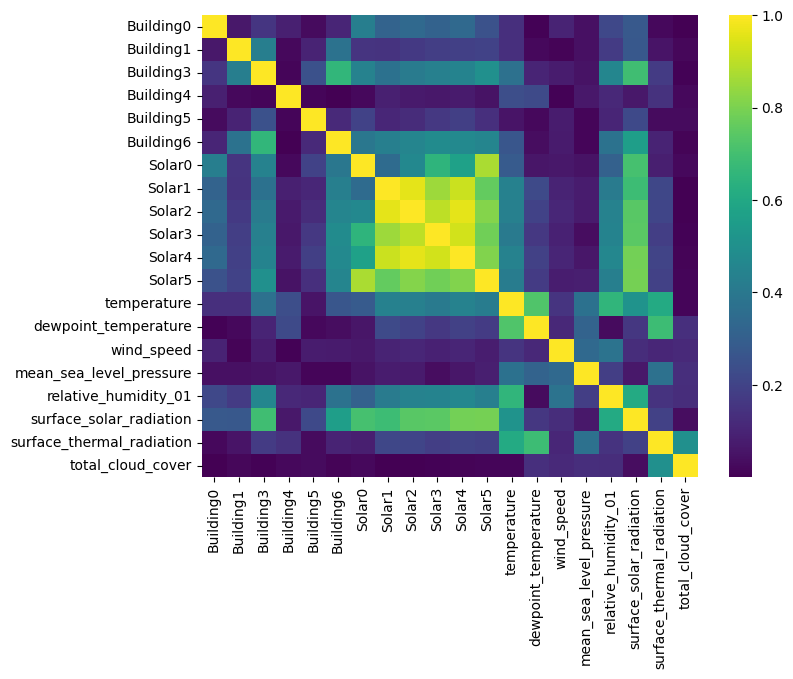

In [12]:
plt.figure(figsize = (8, 6))
sns.heatmap(corr.abs(), cmap ='viridis' )
plt.show()

#### Encontrar las variables altamente correlacionadas

In [13]:
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)

In [14]:
new_corr[new_corr.correlation > 0.5]

,level_0,level_1,correlation
167,Solar2,Solar1,0.957760
208,Solar4,Solar2,0.957152
209,Solar4,Solar3,0.933225
207,Solar4,Solar1,0.921223
188,Solar3,Solar2,0.899917
226,Solar5,Solar0,0.874540
187,Solar3,Solar1,0.853939
228,Solar5,Solar2,0.814985
230,Solar5,Solar4,0.811257
351,surface_solar_radiation,Solar5,0.789889


In [15]:
def plot_histograms(df, columns):
    # keep total number of subplot
    k = len(df.columns)
    # n = number of chart columns
    n = columns
    m = (k - 1) // n + 1
    
    # Create figure
    fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))

    # Iterate through columns, tracking the column name and 
    # which number we are at i. Within each iteration, plot
    for i, (name, col) in enumerate(df.iteritems()):
        r, c = i // n, i % n
        ax = axes[r, c]
        # the histogram
        col.hist(ax=ax)
        # kde = Kernel Density Estimate plot
        ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
        ax2.set_ylim(0)

    # Use tight_layout() as an easy way to sharpen up the layout spacing
    fig.tight_layout()

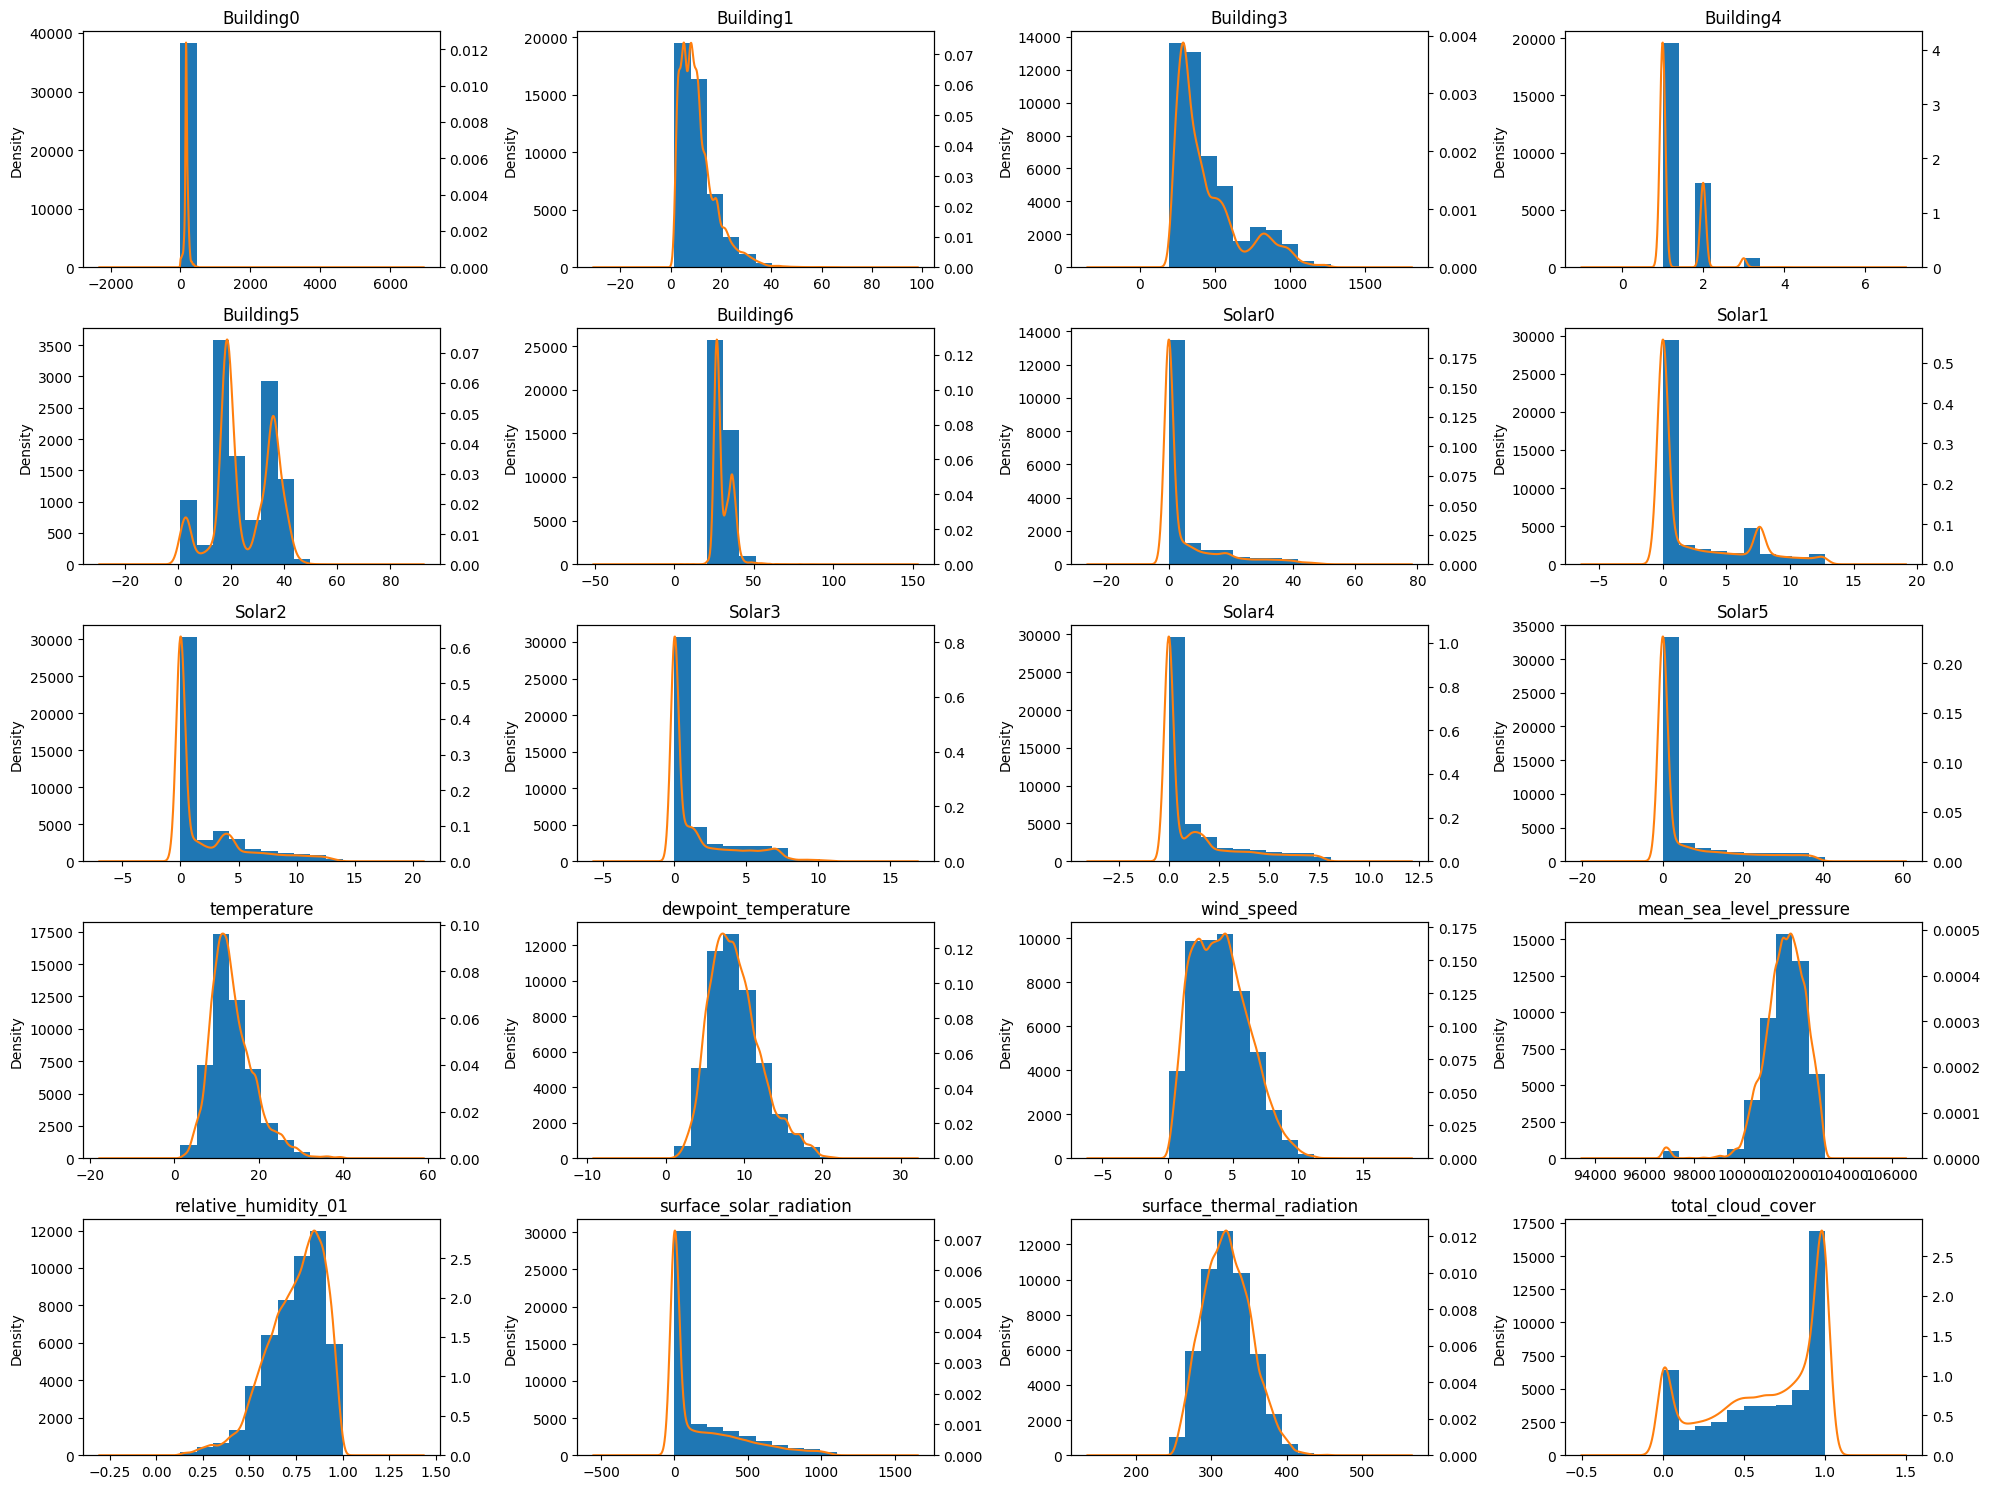

In [16]:
plot_histograms(df=phase2_df[numeric_columns], columns=4)

In [17]:
def univariate(df,col,vartype,hue =None):    
    '''
    Univariate function will plot parameter values in graphs.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuous or categorical
                Continuous(0)   : Distribution & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : Only applicable in categorical analysis.
    '''
    sns.set(style="darkgrid")
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=2,figsize=(20,4))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[1],orient='v')
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
    plt.show()

Building0


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


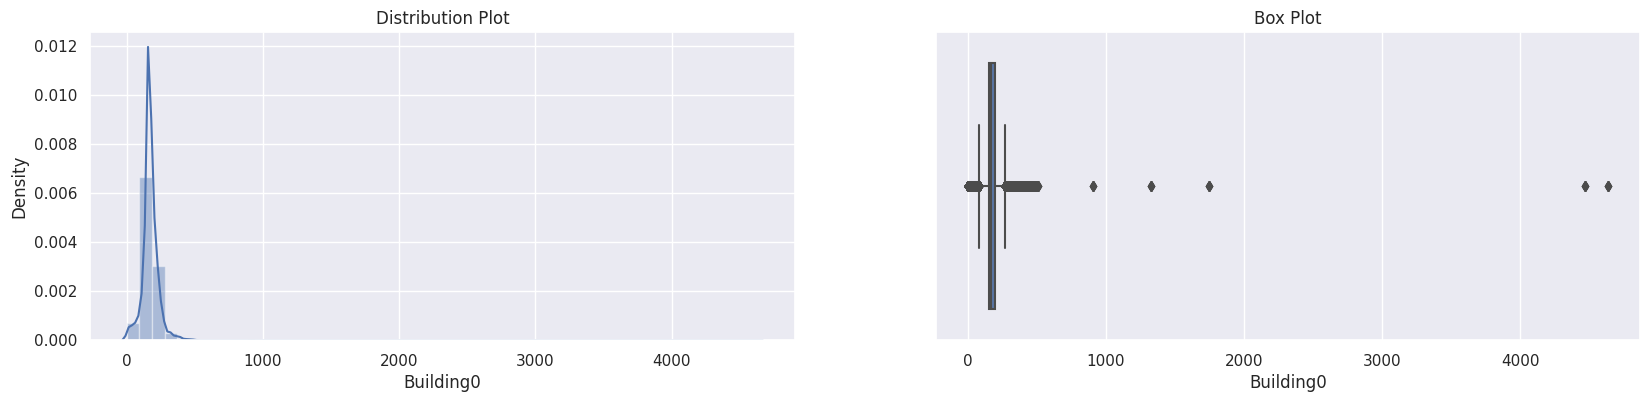

Building1


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


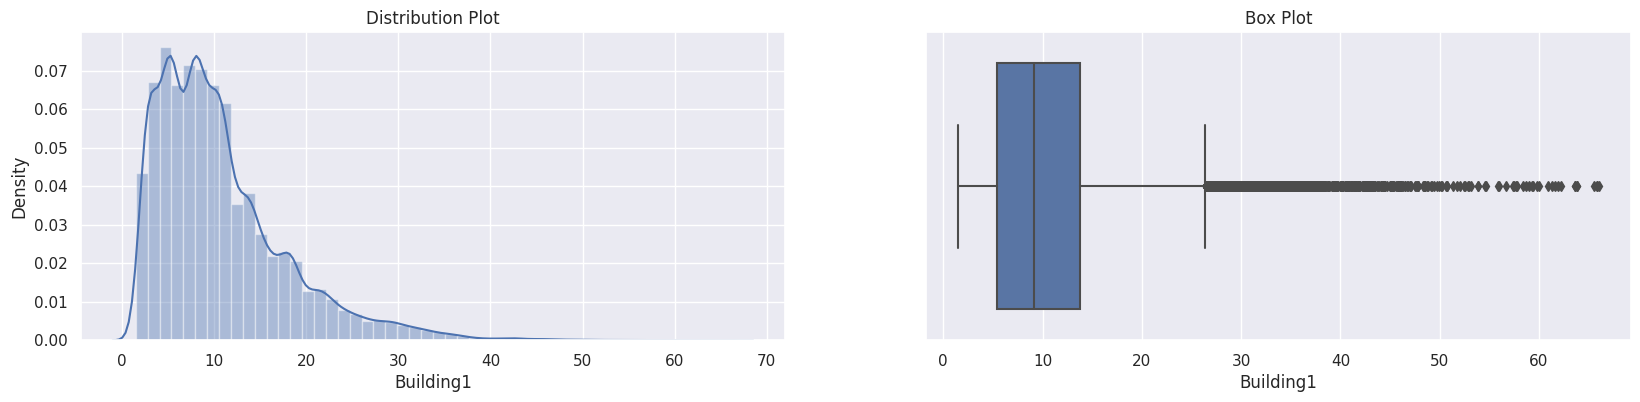

Building3


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


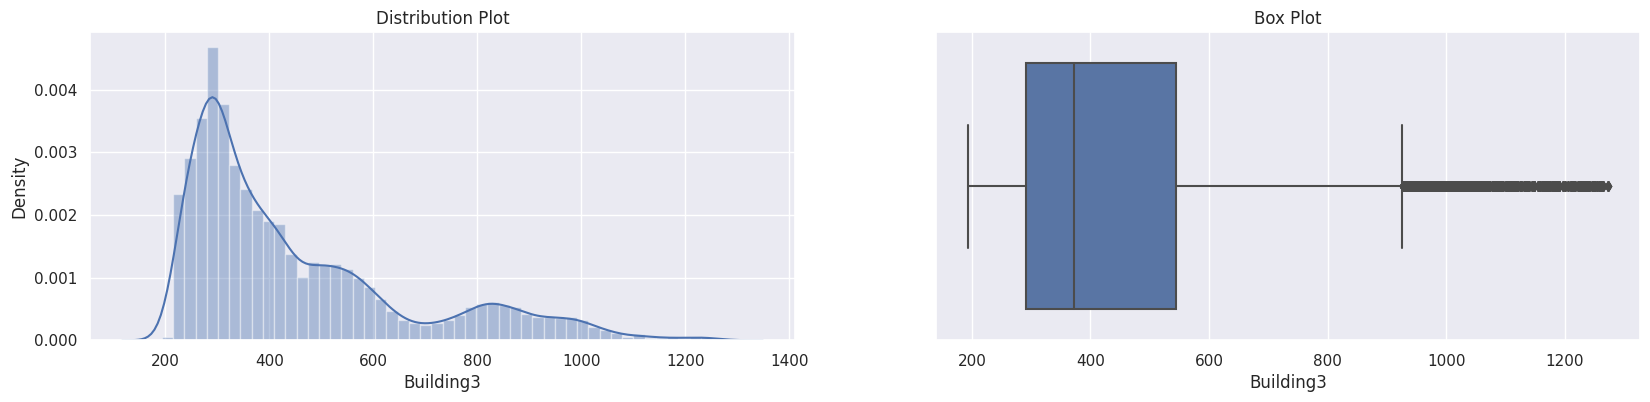

Building4


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


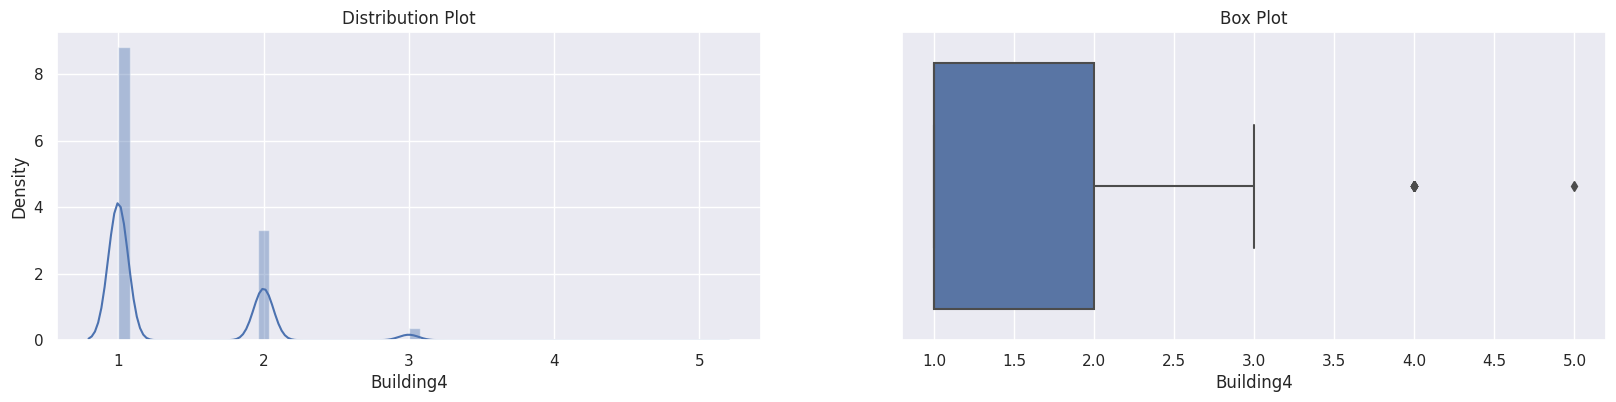

Building5


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


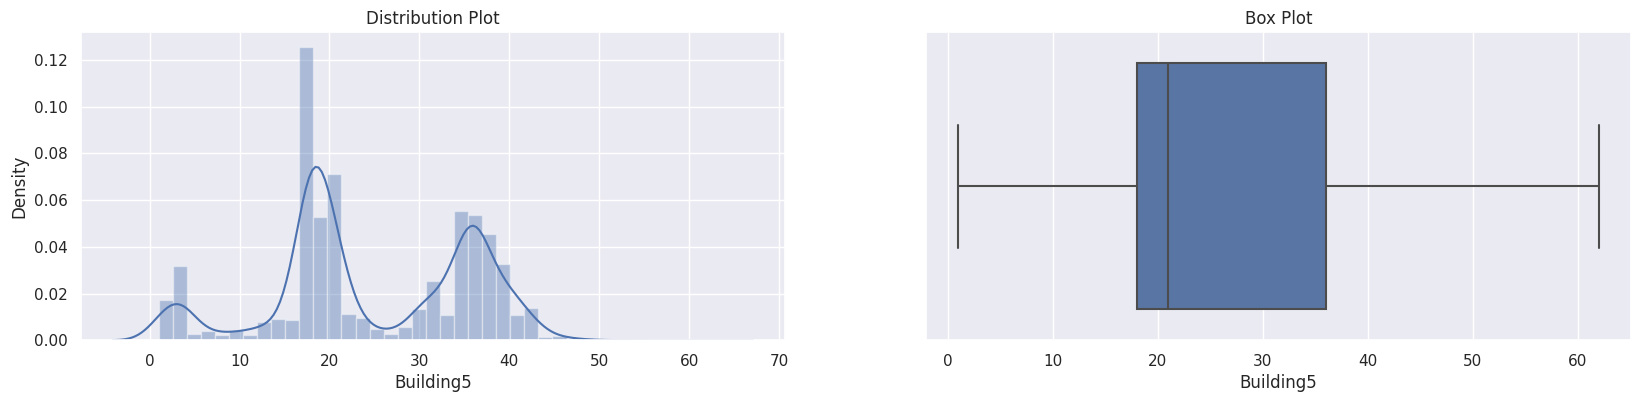

Building6


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


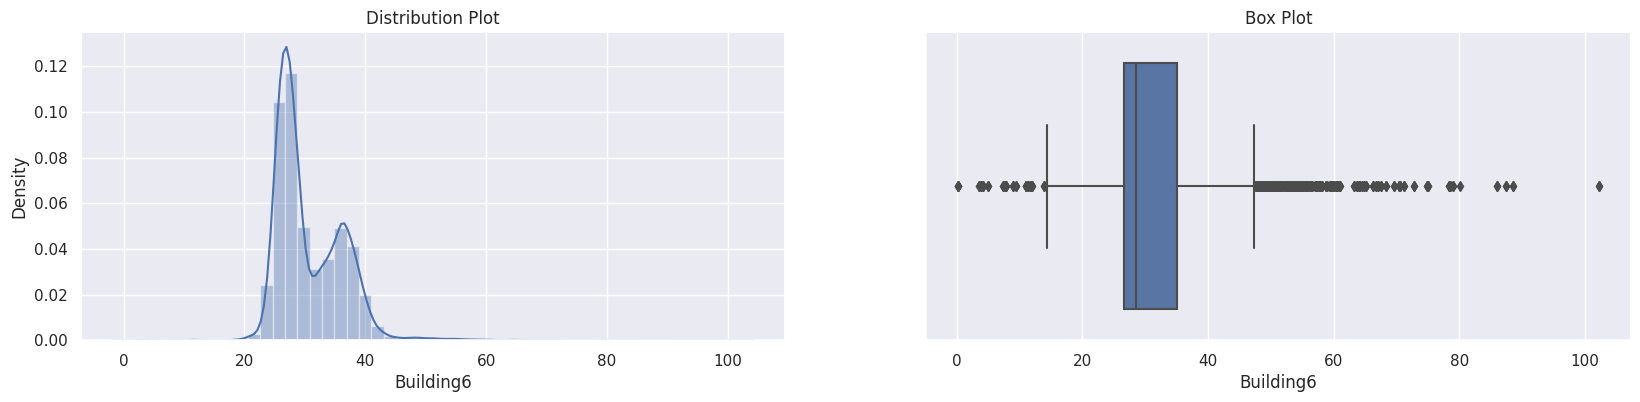

Solar0


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


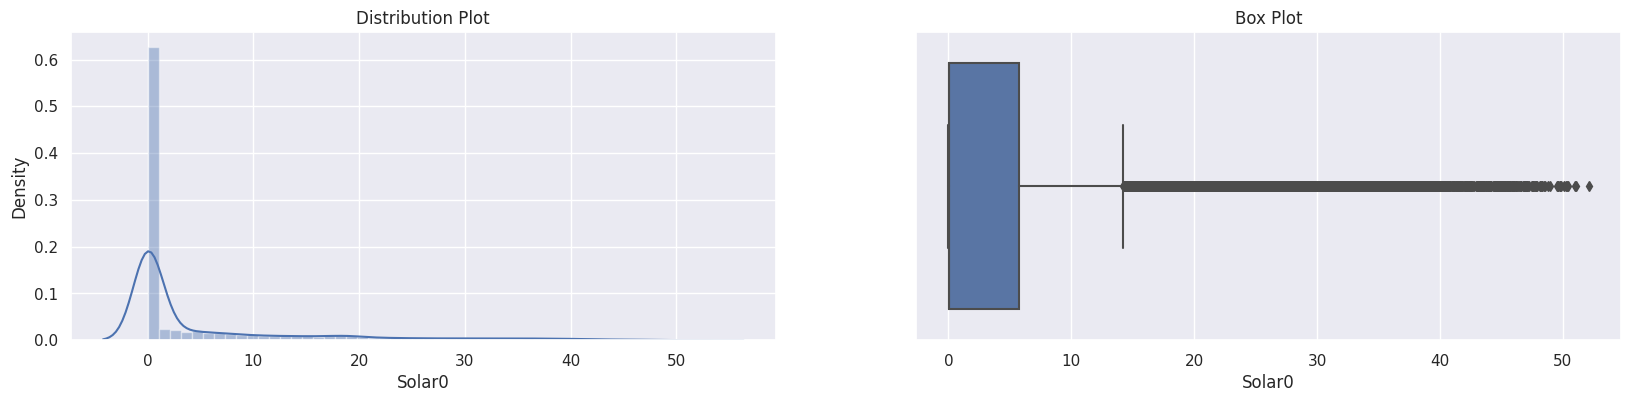

Solar1


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


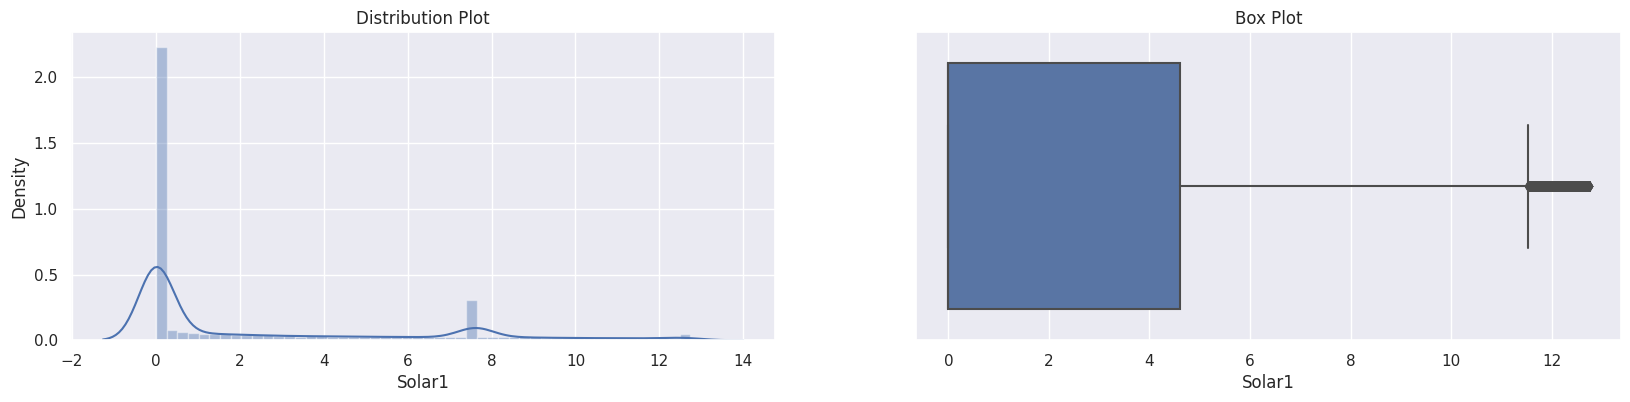

Solar2


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


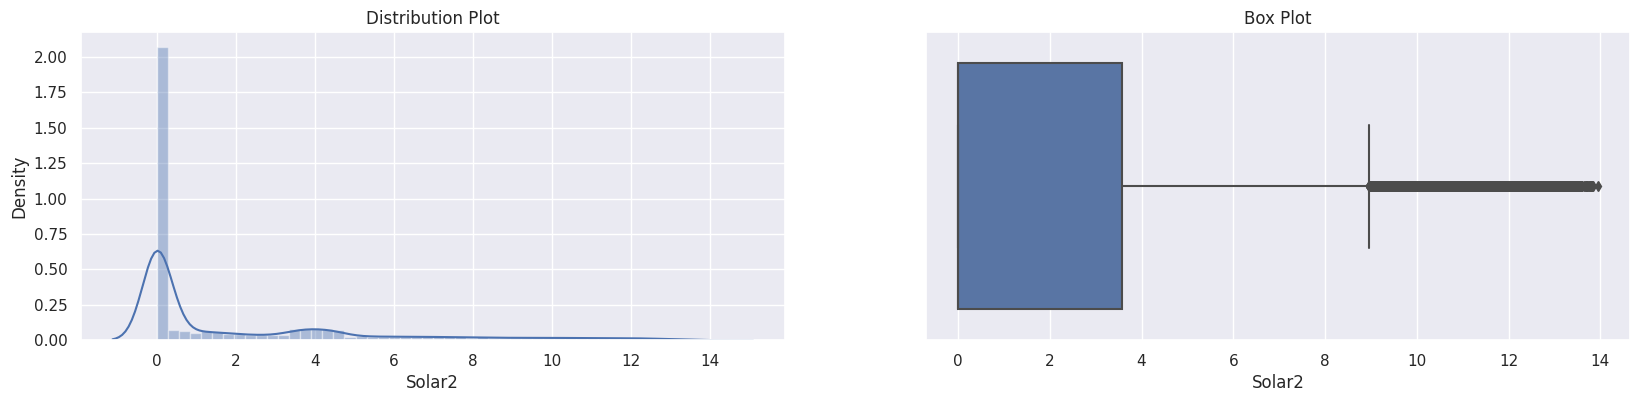

Solar3


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


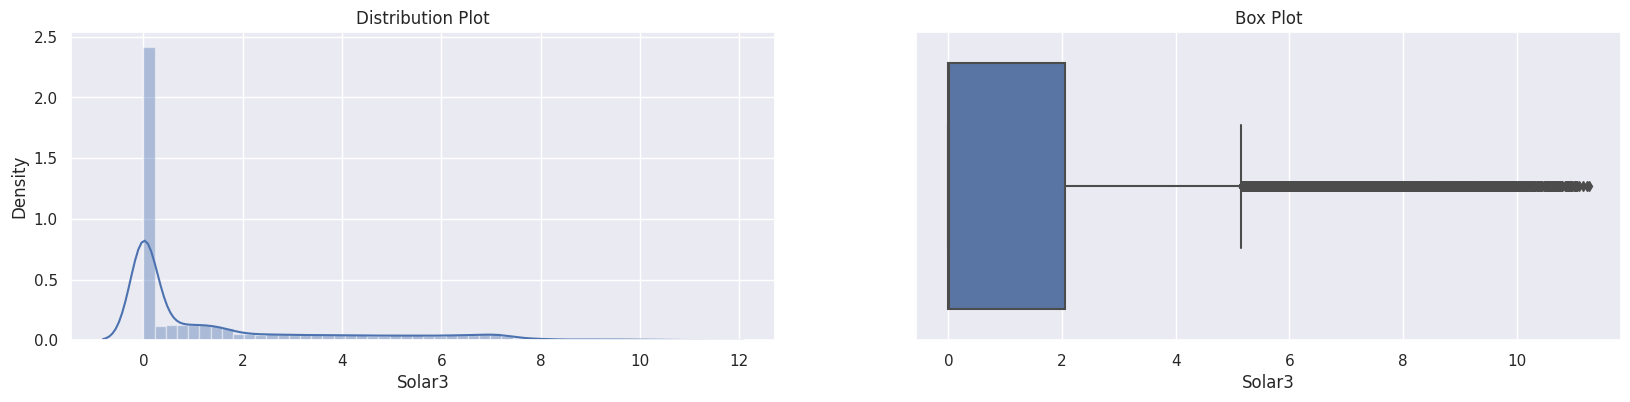

Solar4


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


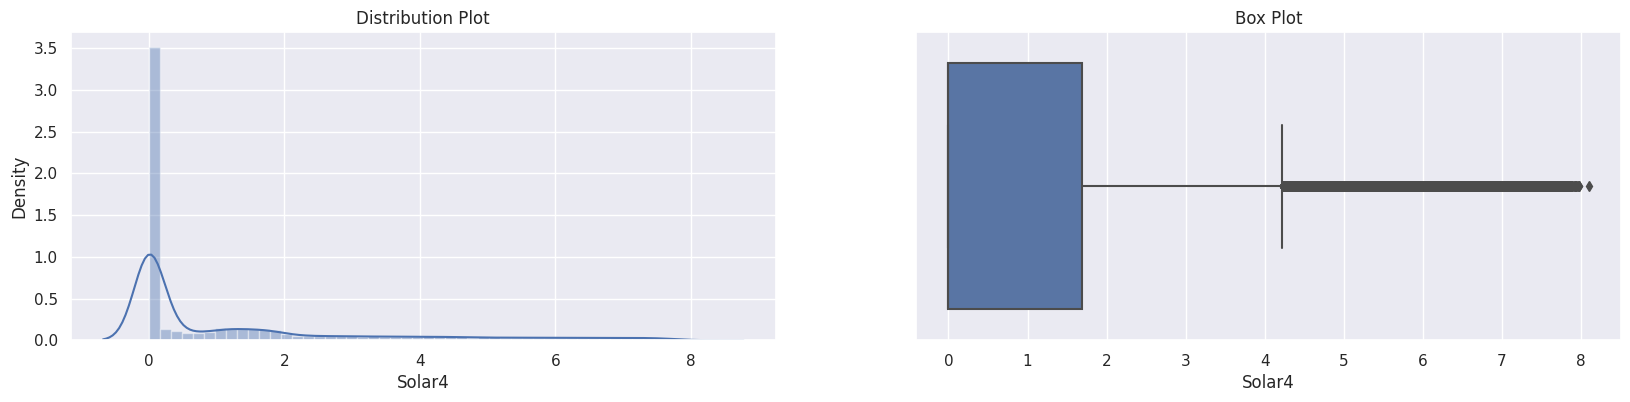

Solar5


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


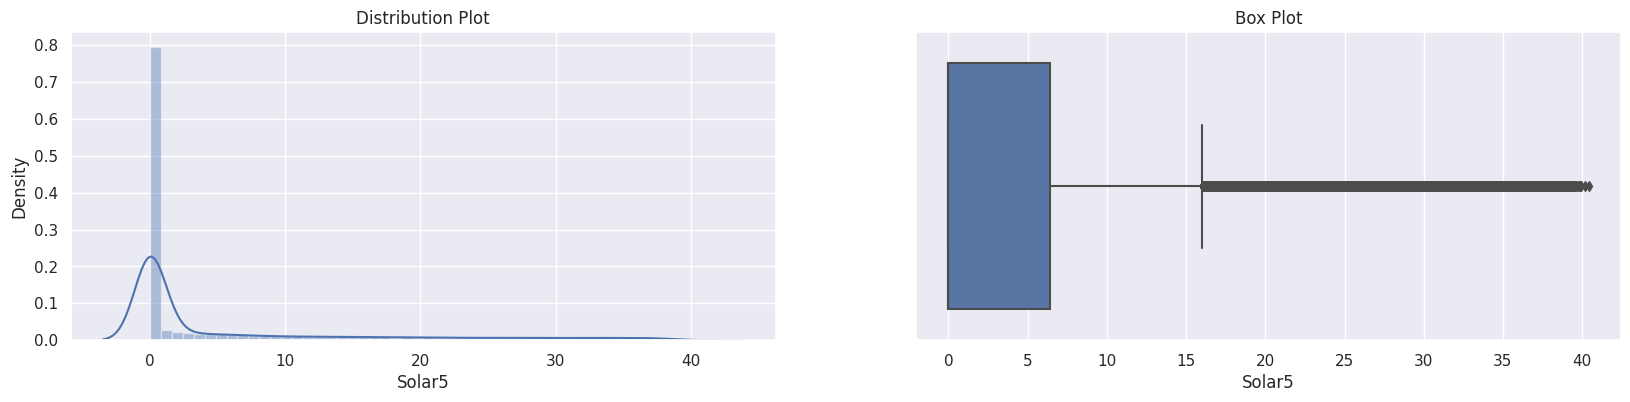

temperature


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


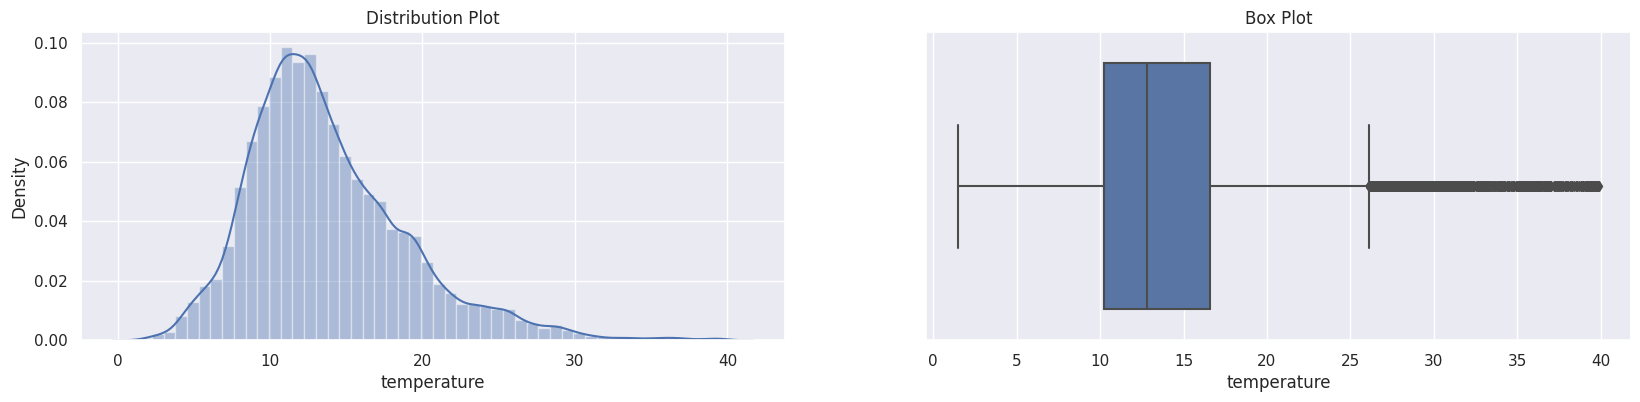

dewpoint_temperature


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


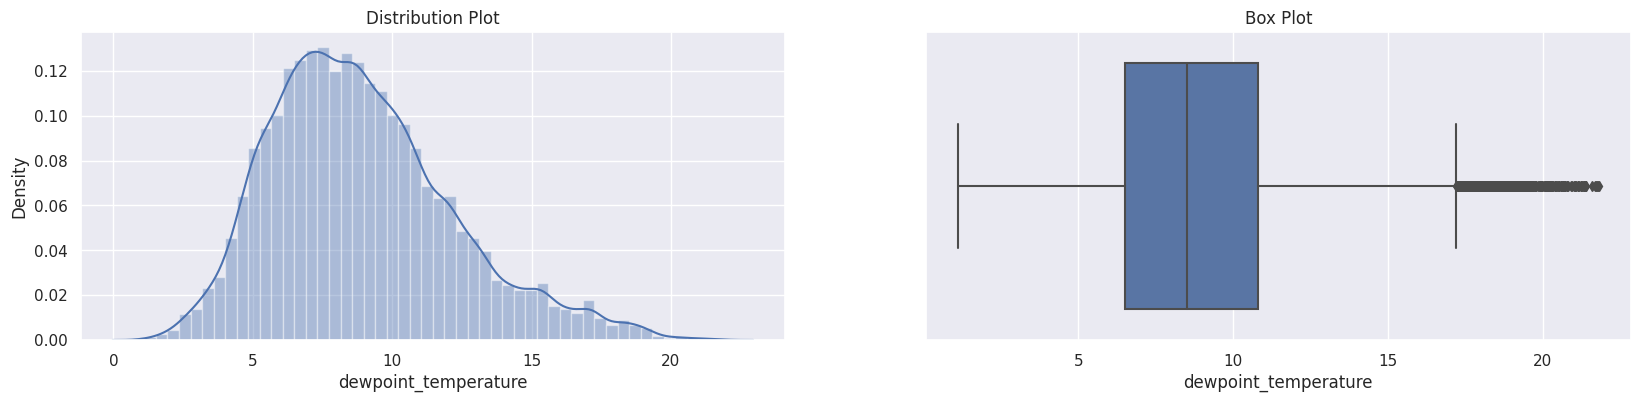

wind_speed


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


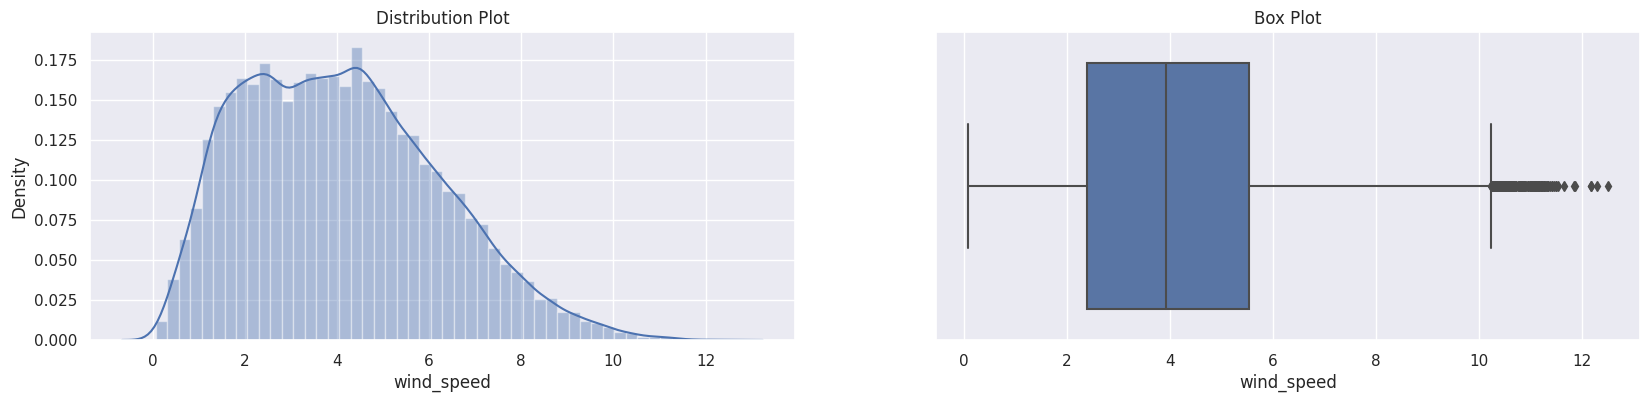

mean_sea_level_pressure


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


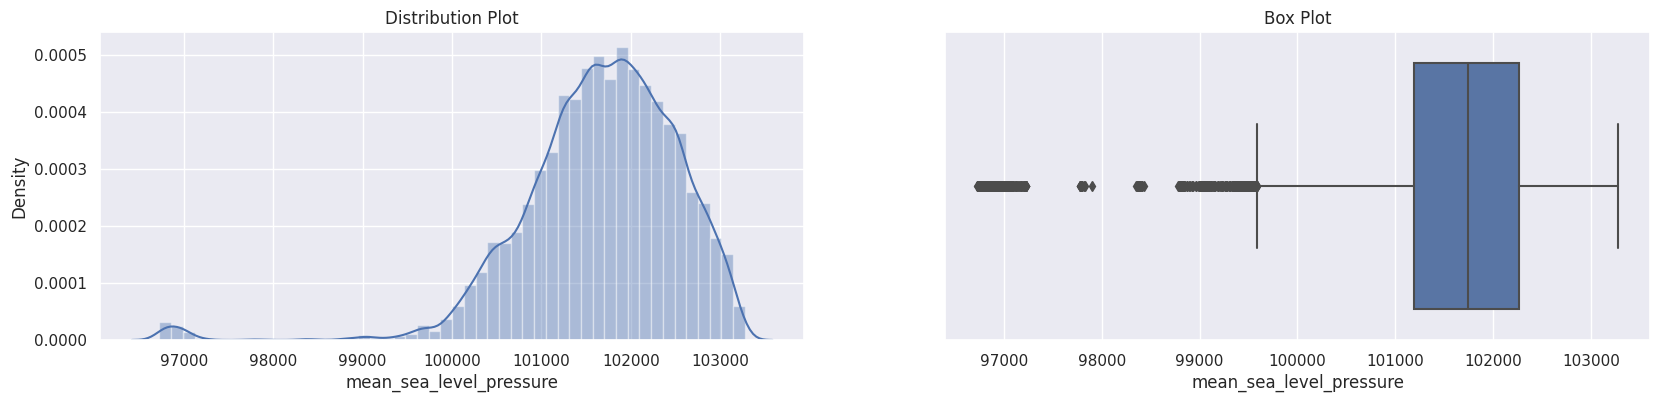

relative_humidity_01


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


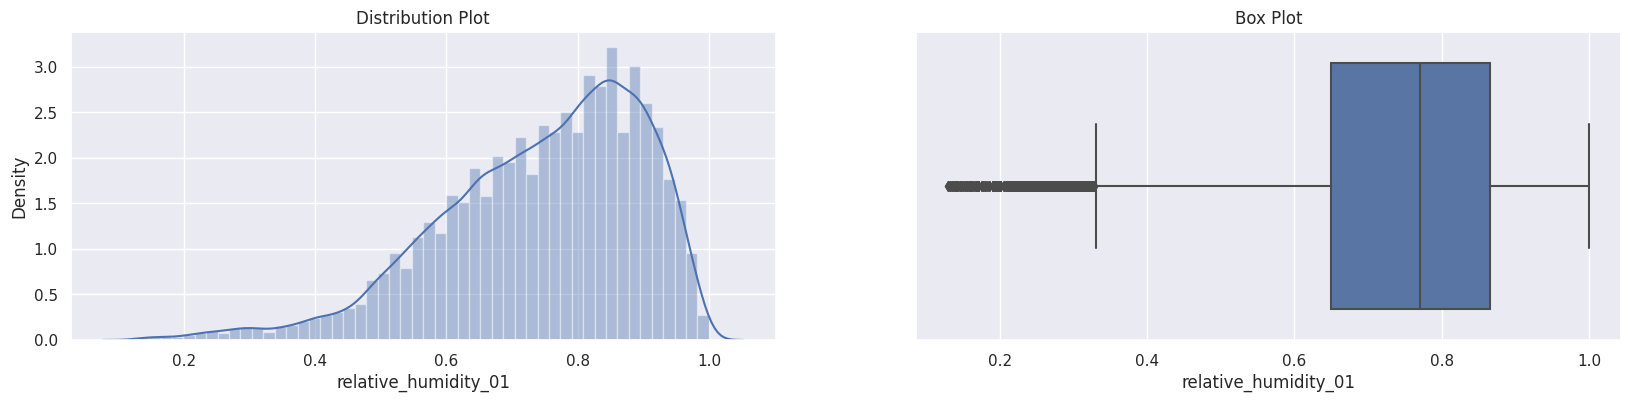

surface_solar_radiation


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


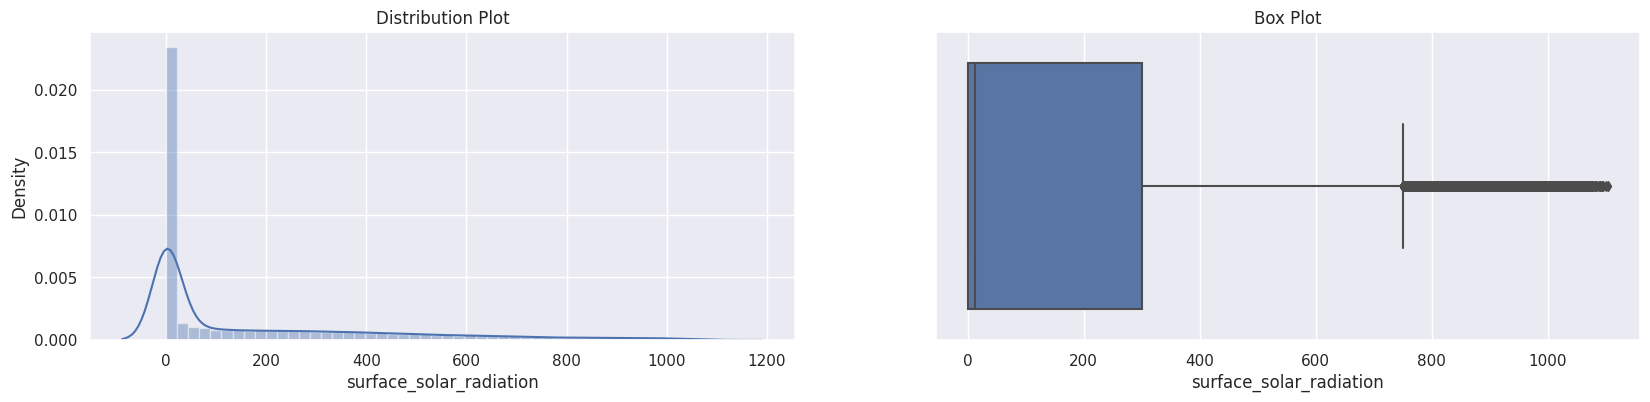

surface_thermal_radiation


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


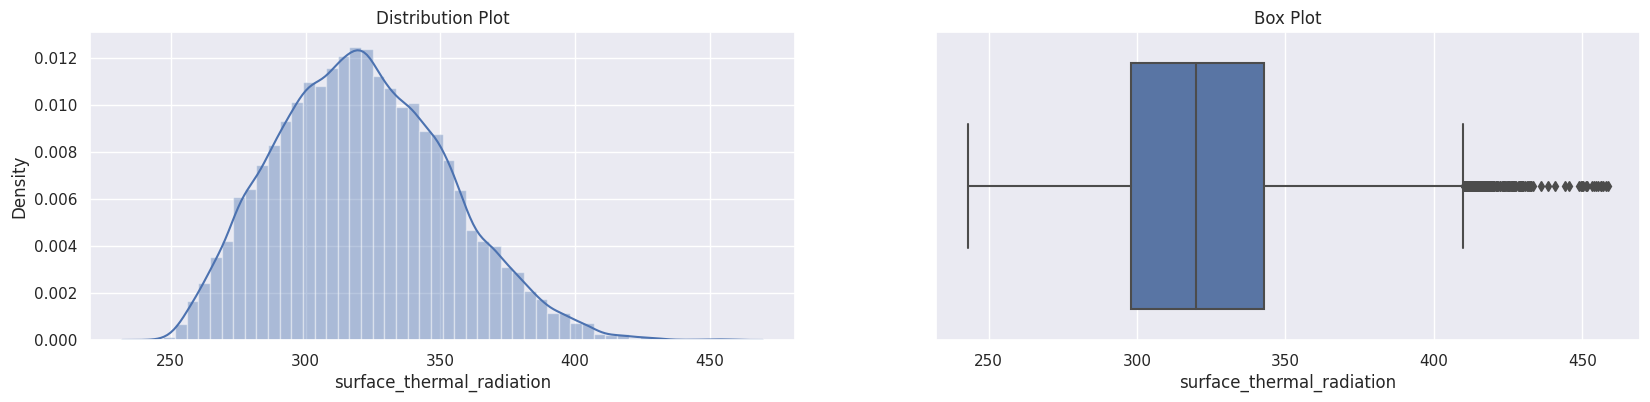

total_cloud_cover


/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/studio-lab-user/.conda/envs/forecast/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


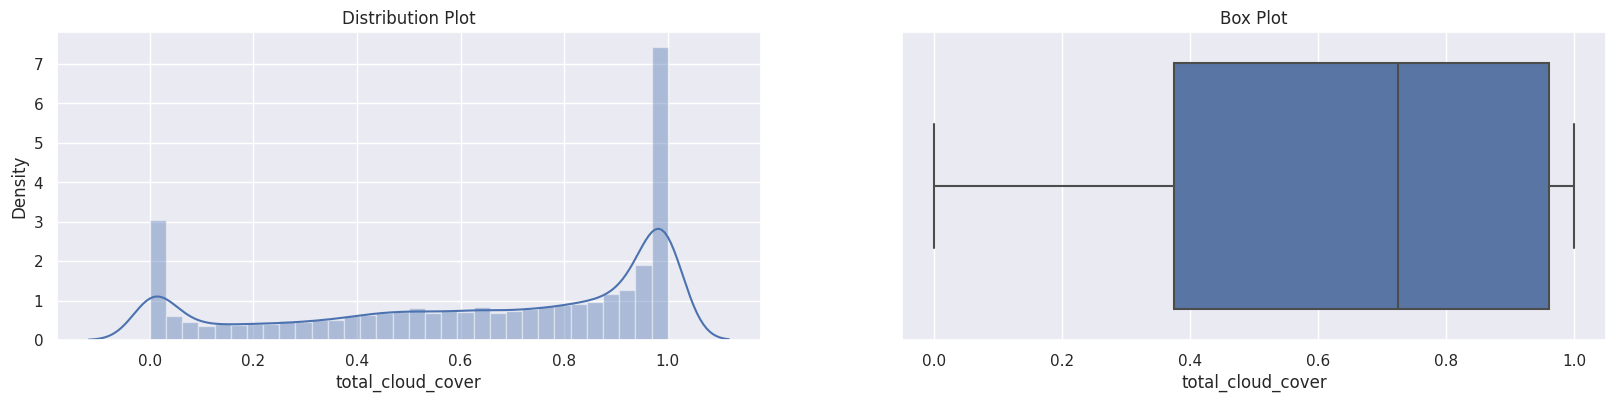

In [18]:
for column in numeric_columns:
    print(column)
    univariate(phase2_df, col=column, vartype=0)

#### Vemos las series temporales de los edificios y paneles

Text(0.5, 1.0, 'Building6')

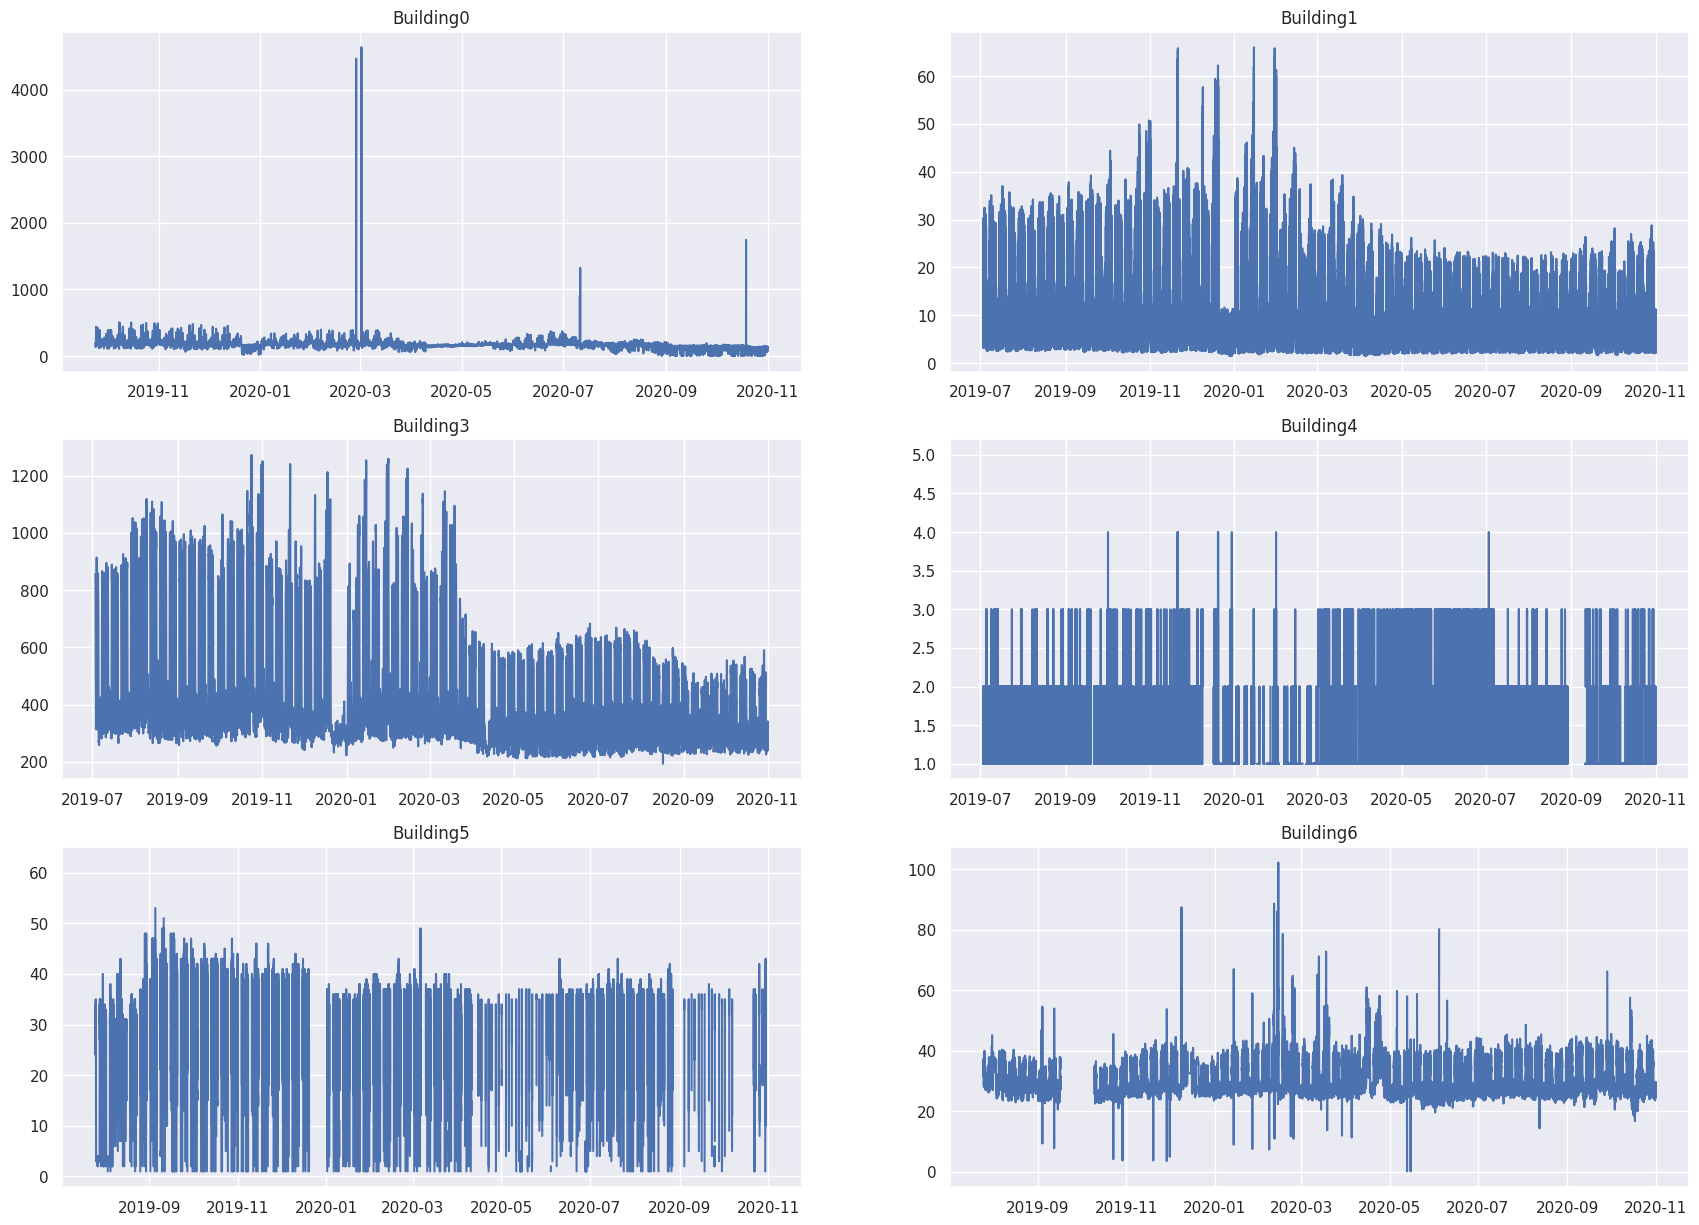

In [19]:
# Visualizamos los Buildings
fig, axs = plt.subplots(3, 2, figsize=(21, 15))
axs[0, 0].plot(phase2_df.index, phase2_df.Building0)
axs[0, 0].set_title('Building0')
axs[0, 1].plot(phase2_df.index, phase2_df.Building1)
axs[0, 1].set_title('Building1')
axs[1, 0].plot(phase2_df.index, phase2_df.Building3)
axs[1, 0].set_title('Building3')
axs[1, 1].plot(phase2_df.index, phase2_df.Building4)
axs[1, 1].set_title('Building4')
axs[2, 0].plot(phase2_df.index, phase2_df.Building5)
axs[2, 0].set_title('Building5')
axs[2, 1].plot(phase2_df.index, phase2_df.Building6)
axs[2, 1].set_title('Building6')

Text(0.5, 1.0, 'Solar5')

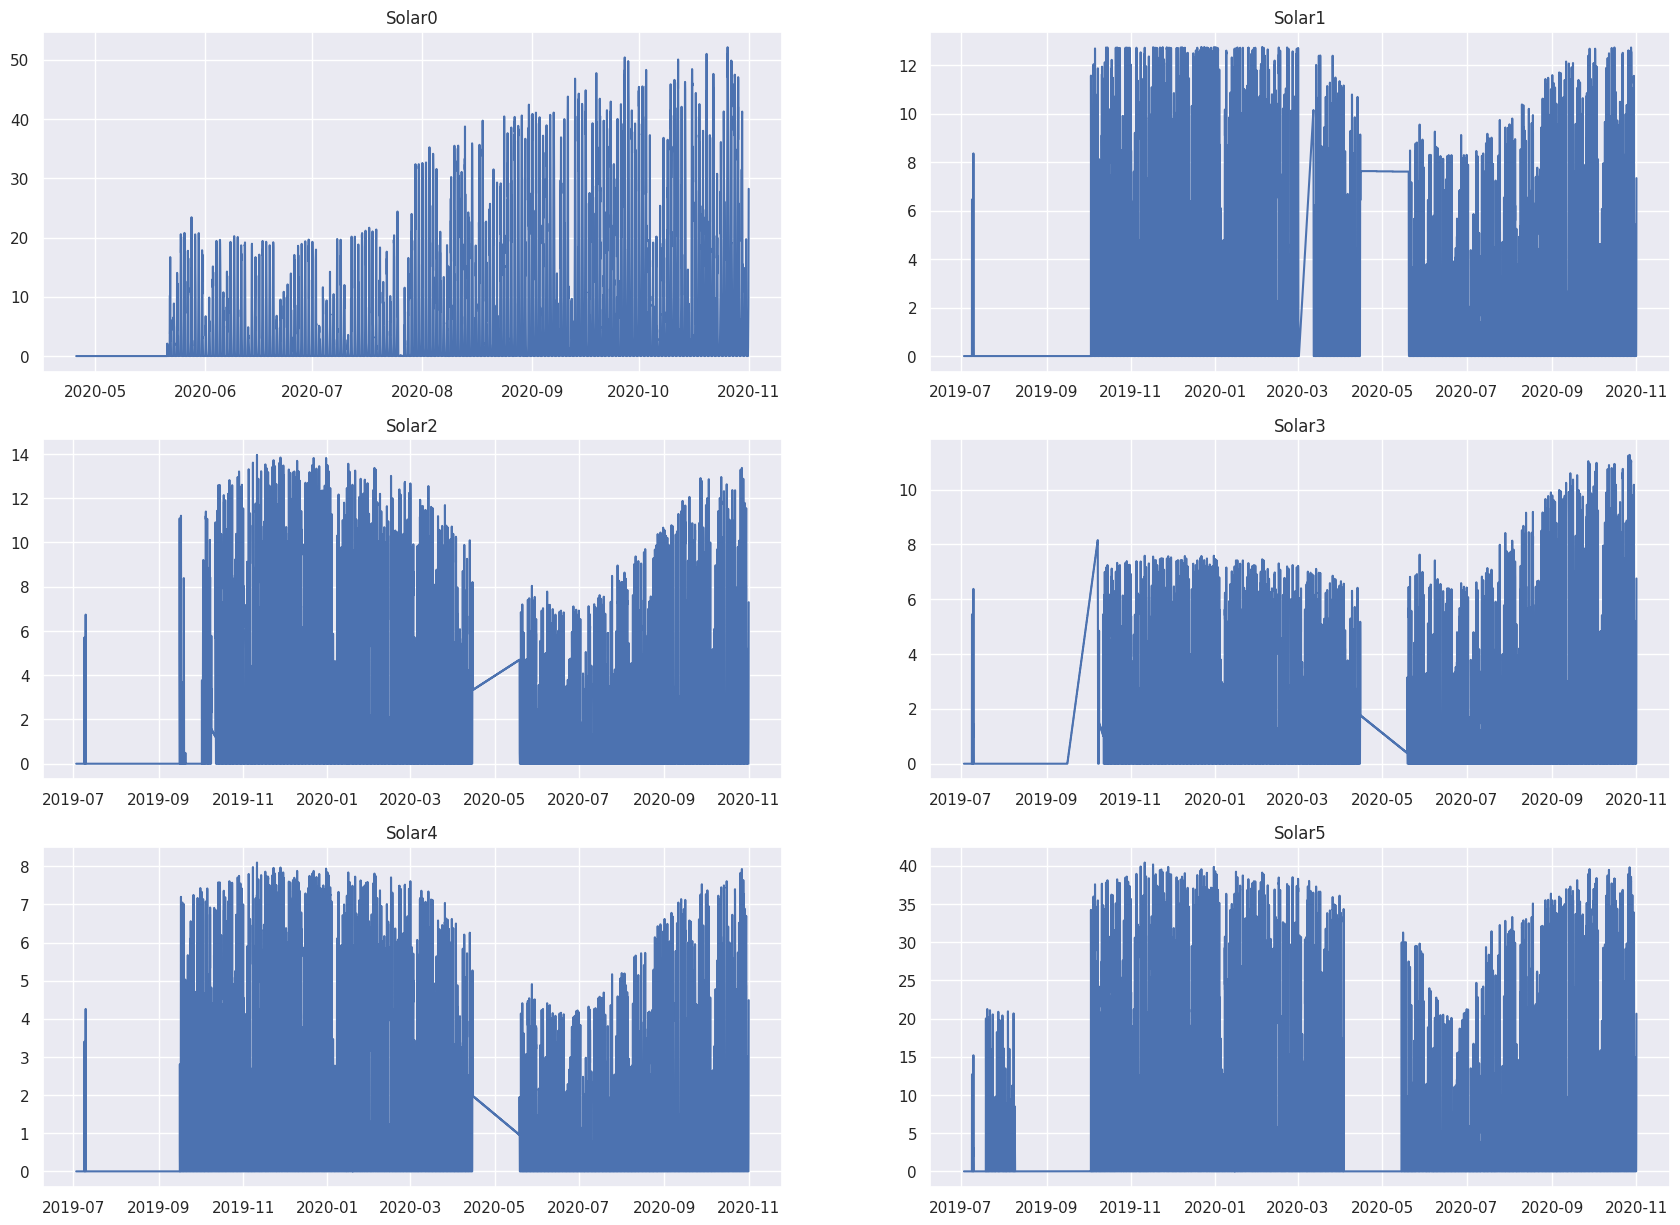

In [20]:
# Visualizamos los Solar Panels
fig, axs = plt.subplots(3, 2, figsize=(21, 15))
axs[0, 0].plot(phase2_df.index, phase2_df.Solar0)
axs[0, 0].set_title('Solar0')
axs[0, 1].plot(phase2_df.index, phase2_df.Solar1)
axs[0, 1].set_title('Solar1')
axs[1, 0].plot(phase2_df.index, phase2_df.Solar2)
axs[1, 0].set_title('Solar2')
axs[1, 1].plot(phase2_df.index, phase2_df.Solar3)
axs[1, 1].set_title('Solar3')
axs[2, 0].plot(phase2_df.index, phase2_df.Solar4)
axs[2, 0].set_title('Solar4')
axs[2, 1].plot(phase2_df.index, phase2_df.Solar5)
axs[2, 1].set_title('Solar5')

----------------------------------------------------

-------------------------------------------------------------------------

## Limpieza de datos

#### Missings

In [21]:
# Separamos los datos de Noviembre del DataFrame que vamos a tratar
Nov_df = phase2_df['2020-11-01 00:00:00':]

phase2_df = phase2_df[:'2020-10-31 23:45:00']

In [22]:
# Usamos interpolación lineal para imputar los datos nulos
phase2_df = phase2_df.interpolate('linear')

# Y los datos no registrados de las estructuras (sus registros empiezan mas tarde que el resto)
# las rellenamos con ceros
phase2_df = phase2_df.fillna(0)

In [23]:
# Faltan por tratar los datos nulos de las series temporales que no tienen datos
# porque no tenemos esos registros hasta pasados unos meses de nuestro punto de partida
# Son:
#     Building0, Building5, Building6 y Solar0

#### Outliers 

In [24]:
Buildings = ['Building0', 'Building1', 'Building3', 'Building4', 'Building5', 'Building6']
Buildings_df = phase2_df[Buildings]

In [25]:
phase2_df.quantile(q = np.arange(0.01, 1, 0.49))

,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5,temperature,dewpoint_temperature,wind_speed,mean_sea_level_pressure,relative_humidity_01,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover
0.01,0.000,2.2,222.00,1.0,0.000000,0.0,0.0000,0.0,0.00,0.0000,0.0,0.00,4.5008,2.860,0.5150,97213.6496,0.2900,0.00,259.4566,0.00
0.50,160.500,9.1,372.00,1.0,9.836066,28.0,0.0000,0.0,0.00,0.0100,0.0,0.00,12.6100,8.345,3.9575,101759.6950,0.7775,10.57,318.8100,0.72
0.99,358.076,34.3,1071.68,3.0,41.000000,46.0,36.6176,12.6,12.38,8.7968,7.4,37.09,29.3817,18.300,9.4092,103126.4949,0.9800,969.69,400.0485,1.00


In [26]:
# Trataremos los outliers de los Builgins usando la tecnica Winsorize.

down_quantiles = Buildings_df.quantile(0.01)
outliers_low = (Buildings_df < down_quantiles)

up_quantiles = Buildings_df.quantile(0.999)
outliers_high = (Buildings_df > up_quantiles)

Buildings_df = Buildings_df.mask(outliers_low, down_quantiles, axis=1)
Buildings_df = Buildings_df.mask(outliers_high, up_quantiles, axis=1)

#### Outliers manuales 

##### Building0

<AxesSubplot:>

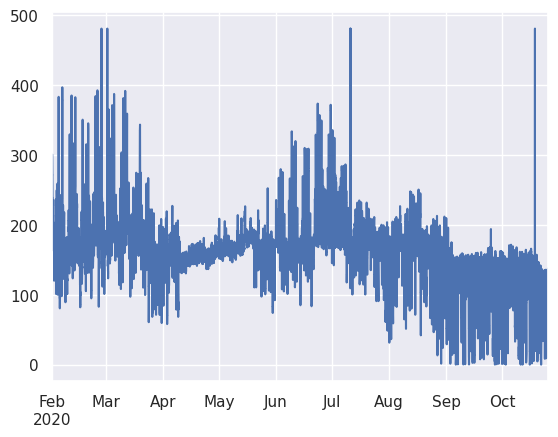

In [27]:
Buildings_df.Building0['2020-02-01' : '2020-10-25'].plot()

In [28]:
#Outliers en Julio y Octubre
Buildings_df.Building0.mask(Buildings_df.Building0['2020-07-01' : '2020-10-20'] > 400, inplace=True)

#Ourliers en Marzo
Buildings_df.Building0.mask(Buildings_df.Building0['2020-02-01' : '2020-04-01'] > 420, inplace=True)

In [29]:
RollMean_B0 = Buildings_df.Building0.rolling(window=5, min_periods=1).mean()
Buildings_df.Building0.fillna(RollMean_B0, inplace=True)

Text(0.5, 1.0, 'Building6')

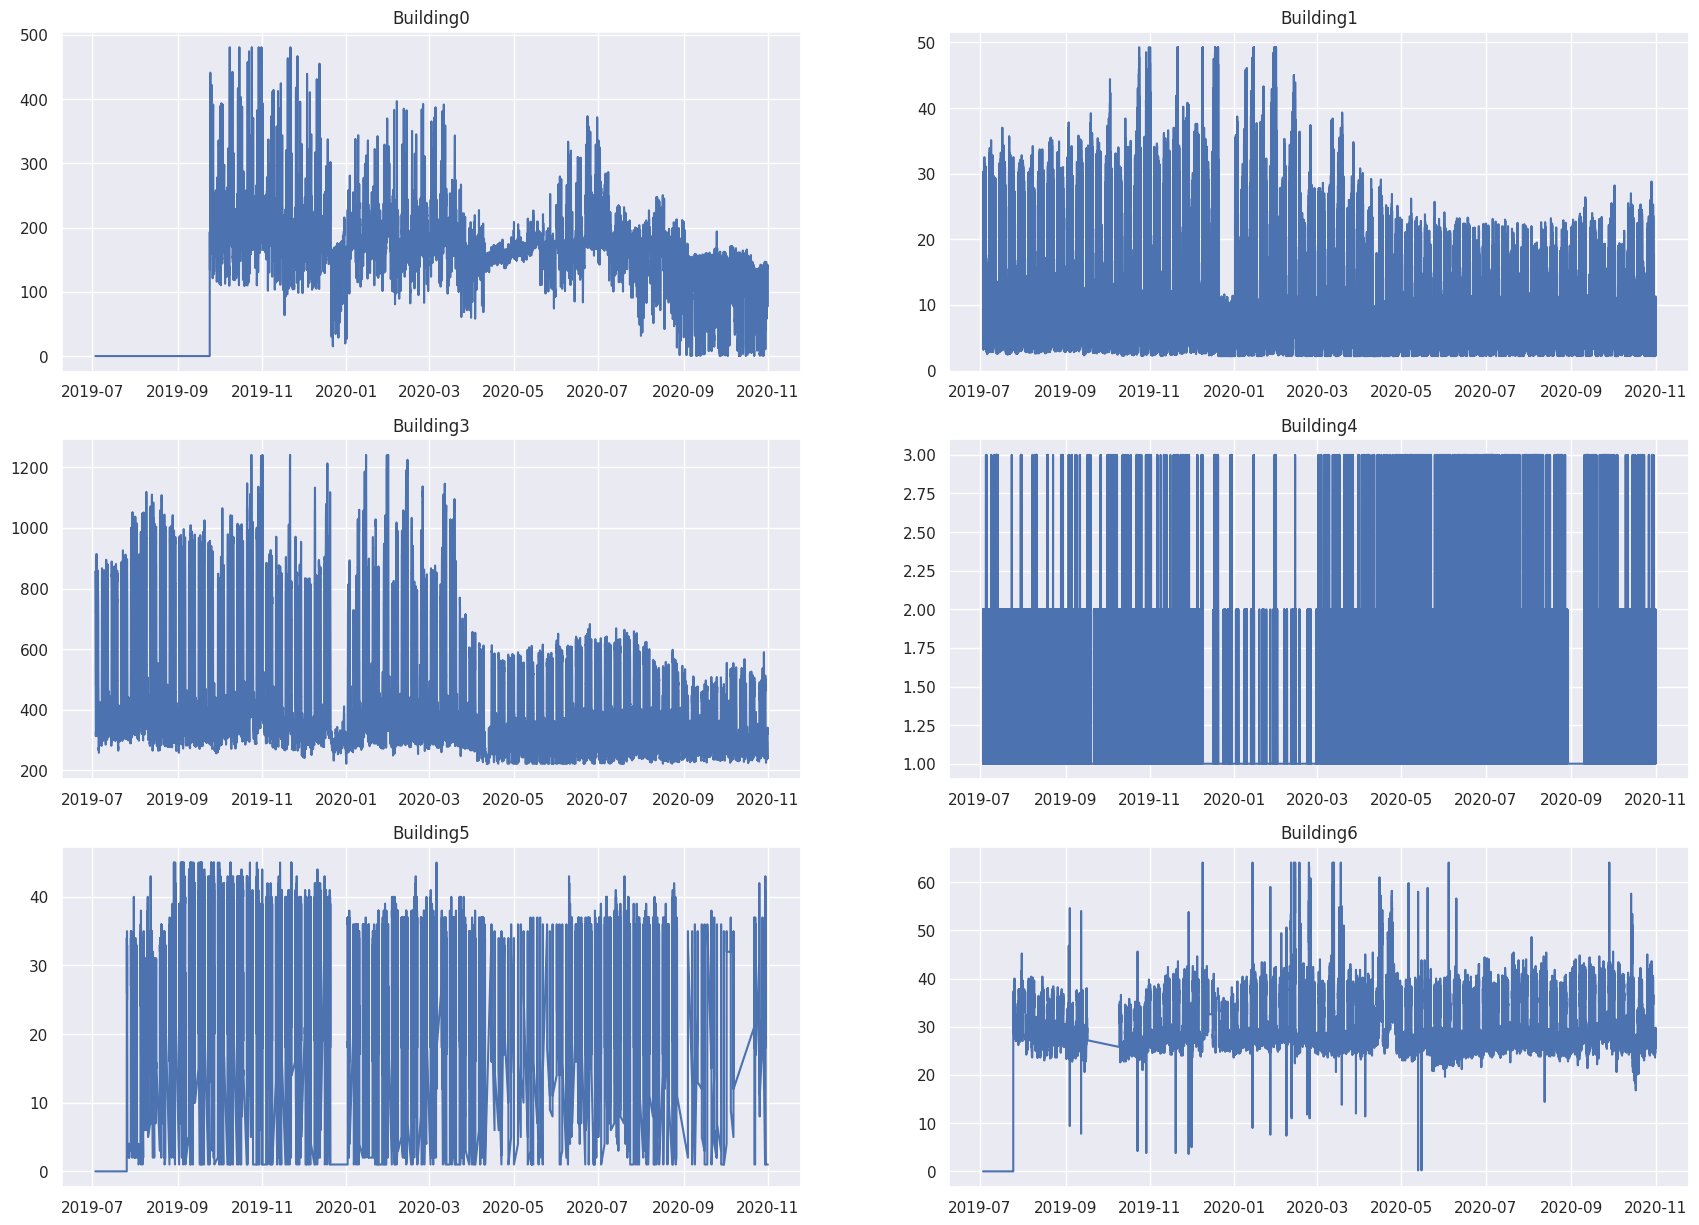

In [30]:
# Visualizamos los Buildings habiendo reducido el valor de los outliers
fig, axs = plt.subplots(3, 2, figsize=(21, 15))
axs[0, 0].plot(Buildings_df.index, Buildings_df.Building0)
axs[0, 0].set_title('Building0')
axs[0, 1].plot(Buildings_df.index, Buildings_df.Building1)
axs[0, 1].set_title('Building1')
axs[1, 0].plot(Buildings_df.index, Buildings_df.Building3)
axs[1, 0].set_title('Building3')
axs[1, 1].plot(Buildings_df.index, Buildings_df.Building4)
axs[1, 1].set_title('Building4')
axs[2, 0].plot(Buildings_df.index, Buildings_df.Building5)
axs[2, 0].set_title('Building5')
axs[2, 1].plot(Buildings_df.index, Buildings_df.Building6)
axs[2, 1].set_title('Building6')

In [31]:
# Llevamos los valores sin outliers al DataFrame original
df_treated = phase2_df.copy()
df_treated[Buildings] = Buildings_df[['Building0', 'Building1', 'Building3', 'Building4', 'Building5', 'Building6']]

No veo que haya outliers en los paneles solares ni en los datos climáticos

#### Feature engineering

In [32]:
# Volvemos a unir los datos de Noviembre para que obtengan las nuevas variables categoricas
df_treated = pd.concat([df_treated ,Nov_df])

In [33]:
df_treated['2020-10-31 23:30:00':'2020-11-01 00:15:00']

,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5,temperature,dewpoint_temperature,wind_speed,mean_sea_level_pressure,relative_humidity_01,surface_solar_radiation,surface_thermal_radiation,total_cloud_cover
2020-10-31 23:30:00,77.6,5.1,327.0,1.0,1.0,27.4,24.56,6.73,6.35,5.83,3.85,18.29,14.2050,9.240,2.880,102392.4250,0.720,446.200,354.6450,0.9600
2020-10-31 23:45:00,77.6,7.8,327.0,1.0,1.0,27.4,28.23,7.34,7.30,6.76,4.49,20.64,14.3225,9.285,2.965,102395.5975,0.715,471.925,355.0175,0.9500
2020-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.4400,9.330,3.050,102398.7700,0.710,497.650,355.3900,0.9400
2020-11-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.7700,9.425,3.120,102397.9950,0.700,544.085,353.8075,0.9425


In [34]:
df_treated.index = pd.to_datetime(df_treated.index).set_names('date')

# Categorical variable for datetime
df_treated['month'] = df_treated.index.map(lambda i: i.strftime('%m'))
df_treated['day'] = df_treated.index.map(lambda i: i.strftime('%d'))
df_treated['hour'] = df_treated.index.map(lambda i: i.strftime('%H'))

# Categorical variable for covid
df_treated['COVID'] = 0
df_treated['COVID']['2020-03-01':] = 1

# Categorical variable for breaks
df_treated['Break'] = 0
df_treated['Break'][:'2020-03-01'] = np.nan
df_treated['Break']['2020-04-10':'2020-04-17'] = 1 # Mid-Semester Break
df_treated['Break']['2020-06-15':'2020-06-19'] = 1 # Swot vac
df_treated['Break']['2020-09-21':'2020-10-02'] = 1 # Mid-Semester Break
df_treated['Break']['2020-11-09':'2020-11-13'] = 1 # Swot vac

# Categorical variable for both semesters
df_treated['Semester'] = 0
df_treated['Semester'][:'2020-03-01'] = np.nan
df_treated['Semester']['2020-03-09':'2020-06-12'] = 1 # Semester 1
df_treated['Semester']['2020-08-03':'2020-11-06'] = 1 # Semester 2

# Categorical variable for exam periods
df_treated['Exams'] = 0
df_treated['Exams'][:'2020-03-01'] = np.nan
df_treated['Exams']['2020-06-22':'2020-07-10'] = 1 # Exams 1
df_treated['Exams']['2020-11-16':'2020-12-04'] = 1 # Exams 2

# Campus Occupancy in %
df_treated['Monash_occupancy'] = 1
df_treated['Monash_occupancy']['2020-06-20':'2020-07-19'] = 0.1
df_treated['Monash_occupancy']['2020-08-02':'2020-09-13'] = 0.05
df_treated['Monash_occupancy']['2020-09-13':'2020-10-18'] = 0.25
df_treated['Monash_occupancy']['2020-10-18':] = 0.3

categorical = ['COVID', 'Break', 'Semester', 'Exams', 'Monash_occupancy',
               'month', 'day', 'hour']
df_treated[categorical] = df_treated[categorical].astype('category')
df_categorical = df_treated[categorical]

print(df_treated.columns)

Index(['Building0', 'Building1', 'Building3', 'Building4', 'Building5',
       'Building6', 'Solar0', 'Solar1', 'Solar2', 'Solar3', 'Solar4', 'Solar5',
       'temperature', 'dewpoint_temperature', 'wind_speed',
       'mean_sea_level_pressure', 'relative_humidity_01',
       'surface_solar_radiation', 'surface_thermal_radiation',
       'total_cloud_cover', 'month', 'day', 'hour', 'COVID', 'Break',
       'Semester', 'Exams', 'Monash_occupancy'],
      dtype='object')


/tmp/ipykernel_3281/767232940.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['COVID']['2020-03-01':] = 1
/tmp/ipykernel_3281/767232940.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['Break'][:'2020-03-01'] = np.nan
/tmp/ipykernel_3281/767232940.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated['Semester'][:'2020-03-01'] = np.nan
/tmp/ipykernel_3281/767232940.py:28: SettingWithCopyWarning:

In [35]:
#Guardamos el DataFrame de Noviembre
Nov_df = df_treated['2020-11-01 00:00:00':]
Nov_df.to_csv('data/Nov_df.csv')

df_treated = df_treated[:'2020-10-31 23:45:00']

# POR HACER


Limpieza de datos -----------> FALTAN Building0, Building5, Building6 y Solar0


Imputación de valores nulos cuando corresponda -> LISTO


Outliers -> LISTO


Ingeniería de variables (por ejemplo, generar una variable día laborable o festivo), One-Hot Encoding -> LISTO


Normalización de variables y escalado (revisar apuntes respecto a esto) -> SOLO PARA GRAFICAS VERDAD?

## + EDA

In [36]:
# PROVISIONAL -----------------------------
# Ponemos este intervalo que es donde empiezan los datos del Building0


df_treated = df_treated['2019-09-24 00:15:00':]



#Guardamos el DataFrame tratado para usarlo en los siguientes notebooks
df_treated.to_csv('data/df_treated.csv')

In [37]:
df_hour = df_treated.resample('H').last()

#### Estacionariedad (Dickey-Fuller)

Usamos la prueba de Dickey-Fuller que nos proporciona una verificación rápida y evidente de si la serie es estacional o no.

**La hipótesis nula** (**H0**) de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria (tiene alguna estructura dependiente del tiempo). **La hipótesis alternativa** (**H1**) (rechazando la hipótesis nula) es que la serie de tiempo es estacionaria.

Interpretamos este resultado utilizando el **p-value**. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza. 

In [40]:
Buildings_df = df_treated[['Building0', 'Building1', 'Building3', 'Building4', 'Building5', 'Building6']]

adf_buildings = {}

for col in Buildings_df.columns.values:
    adf_buildings[col] = adfuller(Buildings_df[col])[1]

In [41]:
#p-value correspondiente a cada building
adf_buildings

{'Building0': 7.919530325648924e-29,
 'Building1': 6.013118255586794e-29,
 'Building3': 1.763027823927992e-23,
 'Building4': 3.2078593923392135e-30,
 'Building5': 8.826469889681827e-29,
 'Building6': 6.526508477405746e-29}

Los 6 buildings poseen series temporales estacionarias

In [46]:
Solars_df = df_treated[['Solar0', 'Solar1', 'Solar2', 'Solar3', 'Solar4', 'Solar5']]

adf_solars = {}

for col in Solars_df.columns.values: 
    adf_solars[col] = adfuller(Solars_df[col])[1]

In [47]:
adf_solars

{'Solar0': 0.0,
 'Solar1': 0.0,
 'Solar2': 0.0,
 'Solar3': 0.0,
 'Solar4': 0.0,
 'Solar5': 0.0}

Los 6 paneles solares tambien poseen series temporales estacionales

In [ ]:
plot_correlations(df_hour.Building0, lags=24)

In [ ]:
res = seasonal_decompose(df_hour.Building0, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

In [ ]:
# Mensual

res = seasonal_decompose(df_hour.Building0['2020-09-01':'2020-10-01'], model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

In [ ]:
# Semanal

res = seasonal_decompose(df_hour.Building0['2020-09-01':'2020-09-07'], model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

In [ ]:
plot_correlations(df_hour.Building0['2020-09-01':'2020-09-07'], lags=7)